Lec2: Lab04: Hough line detection

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/HUST GIFTED CLASS K66/IPSAL LAB/Computer vision/Slides/Tuan7_8/assignment/tuto/'

/content/drive/MyDrive/HUST GIFTED CLASS K66/IPSAL LAB/Computer vision/Slides/Tuan7_8/assignment/tuto


In [8]:
import numpy as np
# from scipy import signal
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [9]:
def normalize_0_255(img):
    min_val = np.min(img)
    max_val = np.max(img)
    new_img = (img - min_val)/(max_val - min_val) # 0 - 1
    new_img *= 255
    return new_img

def normalize_0_1(img):
    min_val = np.min(img)
    max_val = np.max(img)
    new_img = (img - min_val)/(max_val - min_val) # 0 - 1
    return new_img

In [10]:
import os
curent = os.getcwd()
print(curent)

/content/drive/MyDrive/HUST GIFTED CLASS K66/IPSAL LAB/Computer vision/Slides/Tuan7_8/assignment/tuto


Text(0.5, 1.0, 'grayscale')

<Figure size 432x288 with 0 Axes>

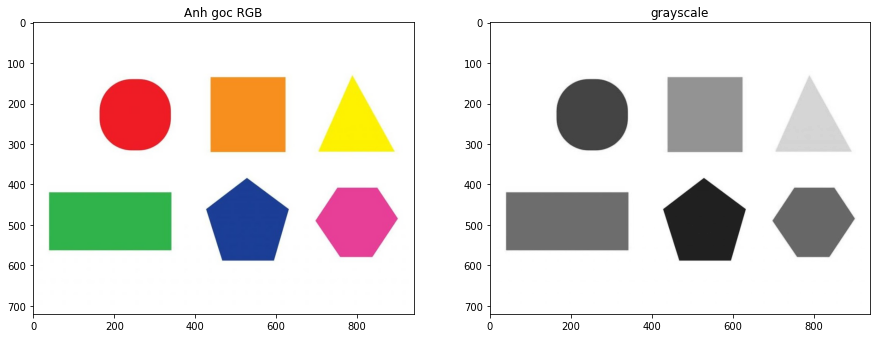

In [11]:
import cv2
from PIL import Image
img = cv2.imread(curent + '/images/geometry.jpg')

img_input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(3)
plt.clf()

plt.figure(figsize = (15, 8))
plt.subplot(121)

plt.imshow(img_input)
plt.title('Anh goc RGB')
plt.subplot(122)
plt.imshow(img_gray, cmap = 'gray')
plt.title('grayscale')

## Phat hien duong thang

In [12]:
edges = cv2.Canny(img_gray, 50, 150, apertureSize = 3)
lines = cv2.HoughLines(edges, rho=1, theta = np.pi/180, threshold = 100)

Text(0.5, 1.0, 'edges')

<Figure size 432x288 with 0 Axes>

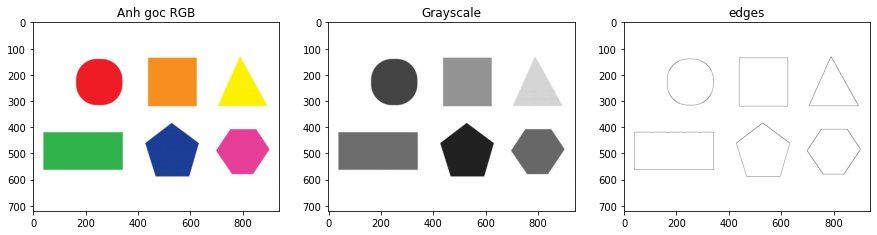

In [13]:
plt.figure(4)
plt.clf()

plt.figure(figsize = (15,8))
plt.subplot(131)
plt.imshow(img_input)
plt.title('Anh goc RGB')
plt.subplot(132)
plt.imshow(img_gray, cmap = 'gray')
plt.title('Grayscale')
plt.subplot(133)
plt.imshow(255-edges, cmap = 'gray')
plt.title('edges')

In [14]:
img_line = img_input
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    output_line_2 = cv2.line(img_line, (x1, y1), (x2, y2), (255, 0, 0), 2)

Text(0.5, 1.0, 'line detected')

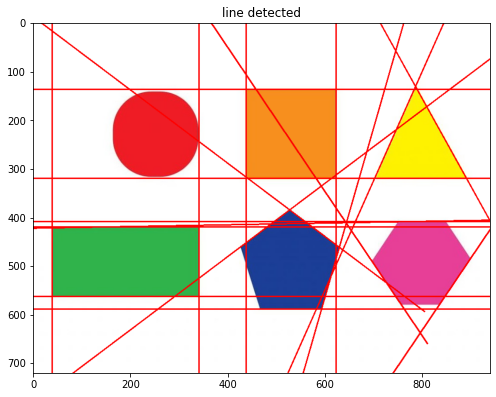

In [16]:
plt.figure(figsize = (18, 8))
plt.subplot(121)
plt.imshow(output_line_2)
plt.title('line detected')

Hàm phát hiện đoạn thẳng theo phương pháp Hough

Thống kê các pixel cạnh nào thuộc đường thằng nào (rho, theta) bằng cách duyệt từng pixel cạnh, tính giá trị rho và so sánh xem nó có khớp với đường thẳng đang xét. Nếu có ta lưu vào danh sách trong từ điển. Siêu tham số cho quá trình xử lí này là rho_delta (default = 1)

Xem xét các pixel thuộc mỗi đường thẳng, từ đó kiểm tra xem pixel sau có liền kề pixel trước hay không (bằng cách so sánh delta x và delta y của chúng với một siêu tham số xác định trước là px_deta (default = 5)). Nếu chúng liền kề thì ta lặp tiếp, nếu không thì đoạn danh sách các pixel vừa duyệt qua tạo thành một đoạn thằng -> kiểm tra 'độ dài' (số pixel) của đoạn thẳng vừa rồi có vượt ngưỡng siêu tham số min_line_length_percent (default = 0.15) so với tổng số pixel thuộc đường đang xét hay không. Nếu nhỏ hơn ngưỡng (tức đây có thể là nhiễu), bỏ qua đoạn thẳng đó. Nếu lơn hơn ngưỡng thì đây là đoạn thẳng cần tìm

In [23]:
import math
import cv2
import numpy as np

def my_hough(img, rho=1, theta = np.pi/180, threshold = 100, rho_delta=1, px_delta = 5, min_line_length_percent = 0.15):
    img_height, img_width = img.shape[:2]
    diagonal_length = int(math.sqrt(img_height**2+img_width**2))

    print('[My Hough] Img Height: %d | Img Width: %d | Img Diagonal Length: %d'%(img_height, img_width, diagonal_length))

    num_rho = int(diagonal_length/rho)
    num_theta = int(np.pi/theta)

    edge_matrix = np.zeros([2*num_rho+1, num_theta]) # dim: num_rho x num_theta

    print('[My Hough] Edge Matrix Dim: %d x %d' % (edge_matrix.shape[0], edge_matrix.shape[1]))

    idx = np.squeeze(cv2.findNonZero(img)) # dim: 4468 x 2 (example, number of white pixel on image processed by canny edge algorithm!)

    range_theta = np.arange(0, np.pi, theta)
    theta_matrix = np.stack((np.cos(np.copy(range_theta)), np.sin(np.copy(range_theta))), axis = 1)

    vote_matrix = np.dot(idx, theta_matrix.T)
    print('[My Hough] Vote Matrix Dim: %d x %d' % (vote_matrix.shape[0], vote_matrix.shape[1]))

    # loop on vote matrix and accumulate values on edge matrix
    for vr in range(vote_matrix.shape[0]):
        for vc in range(vote_matrix.shape[1]):
            rho_pos = int(round(vote_matrix[vr, vc]))+num_rho
            edge_matrix[rho_pos, vc] += 1
    
    print('[My Hough] Sum of Edge Matrix = %d | Max = %d | Min = %d' % (int(np.sum(edge_matrix)), int(np.max(edge_matrix)), int(np.min(edge_matrix))))

    line_idx = np.where(edge_matrix > threshold)

    rho_values = list(line_idx[0])
    rho_values = [r-num_rho for r in rho_values]
    theta_values = list(line_idx[1])
    theta_values = [t/180*np.pi for t in theta_values]

    line_idx = list(zip(rho_values, theta_values))
        # line_idx = [[li] for li in line_idx]

    line_px_dict = {}
    # line_px_dict: {
    #     (rho_0, theta_0): [(x0, y0), (x1, y1), ...]
    #    ...
    #}
    for (rho, theta) in line_idx:
        line_px_dict[(rho, theta)] = [] # init empty list for the key (rho, theta)
        for row_idx in range(idx.shape[0]): #idx dim = 4486 x 2
            point_x, point_y = idx[row_idx, 0], idx[row_idx, 1]
            rho_point = point_x*np.cos(theta) + point_y*np.sin(theta)
            if abs(int(rho_point) - rho) <= rho_delta:
                line_px_dict[(rho, theta)].append((point_x, point_y))
            pass
        pass
    
    # find (xmin, ymin) and (xmax, ymax) of every (rho, theta) in line_px_dic
    line_result = []
    for (rho, theta) in line_px_dict.keys():
        point_list = line_px_dict[(rho, theta)] # [(x0, y0), (x1, y1), ...]
        point_list.sort(key = lambda tup:tup[0]) # sort by x

        pf_idx = 0
        pfrom = point_list[pf_idx]
        pcurrent = pfrom
        for p_idx in range(len(point_list)):
            pto = point_list[p_idx]
            if abs(pto[0]-pcurrent[0]) <= px_delta and abs(pto[1]-pcurrent[1]) <= px_delta and p_idx != len(point_list)-1:
                pcurrent = pto
            else:
                pt_idx = p_idx-1 if p_idx != len(point_list)-1 else p_idx
                pto = point_list[pt_idx]
                line_length_percent = (pt_idx-pf_idx)/len(point_list)

                if line_length_percent >= min_line_length_percent:
                    line_result.append([pfrom, pto])
                else:
                    pass
                pf_idx = p_idx
                pfrom = point_list[p_idx]
                pcurrent = pfrom

    return line_result

In [24]:
import cv2
from PIL import Image
img = cv2.imread((curent + '/images/geometry.jpg'))

img_input= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img_gray, 50, 150, apertureSize=3) # https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny
# cv2.imwrite('store_canny.jpg', edges)    


Ve duong truc tiep len anh

[My Hough] Img Height: 720 | Img Width: 940 | Img Diagonal Length: 1184
[My Hough] Edge Matrix Dim: 2369 x 180
[My Hough] Vote Matrix Dim: 4466 x 180
[My Hough] Sum of Edge Matrix = 803880 | Max = 308 | Min = 0


Text(0.5, 1.0, 'lines overlaid ')

<Figure size 432x288 with 0 Axes>

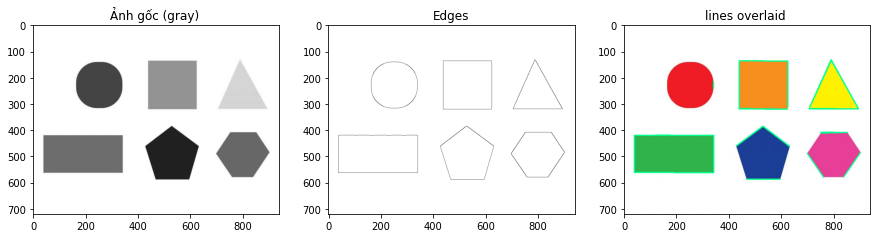

In [25]:
img_input1=img_input
lines = my_hough(edges, rho=1, theta=np.pi/180, threshold=100)
for line in lines:
  (x1, y1) = line[0]
  (x2, y2) = line[1]
  # out_line=cv2.line(img_input, (x1,y1), (x2,y2),(255,0,143), 3)
  out_line=cv2.line(img_input, (x1,y1), (x2,y2),(0,255,143), 3)       
cv2.imwrite('store_line.jpg',img_input)
im_to_show=cv2.imread('store_line.jpg')
plt.figure()
plt.clf()
# plt.imshow(img1)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(img_gray,cmap='gray')
plt.title('Ảnh gốc (gray) ')
plt.subplot(132)
plt.imshow(255-edges,cmap='gray')
plt.title('Edges')
plt.subplot(133)
# plt.imshow(im_to_show)
plt.imshow(out_line)
plt.title('lines overlaid ')

Chi ve ca duong tim ra

[My Hough] Img Height: 720 | Img Width: 940 | Img Diagonal Length: 1184
[My Hough] Edge Matrix Dim: 2369 x 180
[My Hough] Vote Matrix Dim: 4466 x 180
[My Hough] Sum of Edge Matrix = 803880 | Max = 308 | Min = 0


Text(0.5, 1.0, 'lines only')

<Figure size 432x288 with 0 Axes>

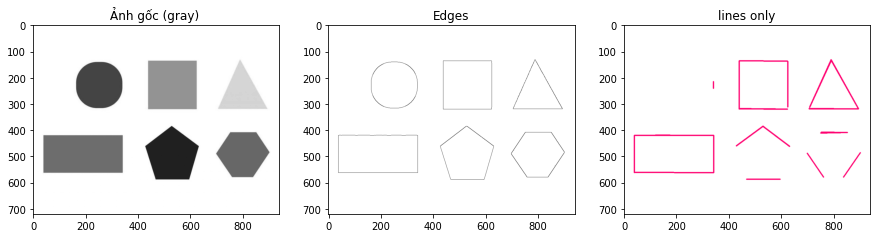

In [27]:
import cv2
from PIL import Image
img = cv2.imread((curent+"/images/geometry.jpg"))

img_input= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img_gray, 50, 150, apertureSize=3) # https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny
# cv2.imwrite('store_canny.jpg', edges)    
img_input1=img_input
img_draw=0*img_input
lines = my_hough(edges, rho=1, theta=np.pi/180, threshold=100)
for line in lines:
  (x1, y1) = line[0]
  (x2, y2) = line[1]
  # out_line=cv2.line(img_input, (x1,y1), (x2,y2),(255,0,143), 3)
  out_line=cv2.line(img_draw, (x1,y1), (x2,y2),(0,255,143), 3)       
cv2.imwrite('store_line.jpg',img_draw)
im_to_show=cv2.imread('store_line.jpg')

plt.figure()
plt.clf()
# plt.imshow(img1)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(img_gray,cmap='gray')
plt.title('Ảnh gốc (gray) ')
plt.subplot(132)
plt.imshow(255-edges,cmap='gray')
plt.title('Edges')
plt.subplot(133)
# plt.imshow(im_to_show)
plt.imshow(255-out_line)

plt.title('lines only')
